In [1]:
"""
Benchmark: 1D Schnakenberg Reaction-Diffusion System
====================================================

This benchmark compares the performance of implicit Runge-Kutta solvers
when using sparse versus dense Jacobian representations.

Problem description
-------------------
We solve the Schnakenberg reaction-diffusion system in 1D:

    ∂u/∂t = D_u ∂²u/∂x² + a - u + u²v
    ∂v/∂t = D_v ∂²v/∂x² + b - u²v

on the spatial domain x ∈ (0, 1) with homogeneous Dirichlet boundary
conditions (u = v = 0 at the boundaries). The parameters are:

    a = 0.2,    b = 1.3
    D_u = 1e-3, D_v = 5e-3

Discretization
--------------
The spatial domain is discretized with N interior points and uniform
grid spacing h = 1 / (N + 1). A standard finite-difference Laplacian
is used for the diffusion operator. This yields a system of ODEs in
time of dimension 2N:

    U = (u₁, ..., u_N, v₁, ..., v_N)ᵀ ∈ ℝ²ᴺ.

ODE System
----------
The resulting semi-discrete system is integrated in time with an
implicit Runge-Kutta scheme (SDIRK(3,4) by Nørsett-Thompson). The
benchmark compares two implementations of the Jacobian:

    • Dense Jacobian: stored and factored as a full 2N x 2N matrix.
    • Sparse Jacobian: block sparse representation with CSR format.

Goal
----
To measure the impact of Jacobian sparsity on runtime efficiency
for moderately large problems (here N = 200).

Expected behavior:
- Sparse storage/factorization should reduce computational cost and
  memory footprint compared to the dense approach.
"""

import time
import numpy as np
import scipy.sparse as sp
from scipy.sparse import diags, bmat
from matplotlib import pyplot as plt

from pyodys import ODEProblem, RKSolver


In [2]:


# ---------------------------------------------------------------------------
# Model parameters
# ---------------------------------------------------------------------------
a, b = 0.2, 1.3        # Schnakenberg reaction parameters
D_u, D_v = 1e-3, 5e-3  # Diffusion coefficients

# ---------------------------------------------------------------------------
# Utilities
# ---------------------------------------------------------------------------
def laplacian_1d(N: int, h: float) -> sp.csr_matrix:
    """Construct 1D Laplacian with Dirichlet BC."""
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N-1)
    return diags([off_diag, main_diag, off_diag], [-1,0,1], format='csr') / (h**2)

# ---------------------------------------------------------------------------
# Schnakenberg 1D problem
# ---------------------------------------------------------------------------
class Schnakenberg1D(ODEProblem):
    """1D Schnakenberg reaction-diffusion system."""
    
    def __init__(self, N: int, t_init: float, t_final: float, force_dense: bool = False):
        self.N = N
        self.h = 1.0 / (N + 1)
        self.x = np.linspace(self.h, 1.0 - self.h, N)
        self.force_dense = force_dense

        # Steady-state solution with perturbation
        u0 = a + b
        v0 = b / (a + b)**2
        rng = np.random.default_rng(12345)
        perturb = 0.02 * rng.standard_normal(size=(N,))
        U = u0 + perturb
        V = v0 + perturb
        initial_state = np.hstack([U, V])

        self.L = laplacian_1d(N, self.h)
        super().__init__(t_init, t_final, initial_state, jacobian_is_constant=False, mass_matrix_is_identity=True)

    def evaluate_at(self, t: float, U: np.ndarray) -> np.ndarray:
        u = U[:self.N]
        v = U[self.N:]
        rhs_u = D_u * self.L.dot(u) + (a - u + u**2 * v)
        rhs_v = D_v * self.L.dot(v) + (b - u**2 * v)
        return np.concatenate([rhs_u, rhs_v])

    def jacobian_at(self, t: float, U: np.ndarray):
        u = U[:self.N]
        v = U[self.N:]
        n = self.N
        if self.force_dense:
            J = np.zeros((2*n, 2*n))
            J[:n,:n] = D_u*self.L.toarray() + np.diag(-1 + 2*u*v)
            J[:n,n:] = np.diag(u**2)
            J[n:,:n] = np.diag(-2*u*v)
            J[n:,n:] = D_v*self.L.toarray() + np.diag(-u**2)
            return J
        else:
            R_uu = diags(-1 + 2*u*v, 0, format='csr')
            R_uv = diags(u**2, 0, format='csr')
            R_vu = diags(-2*u*v, 0, format='csr')
            R_vv = diags(-u**2, 0, format='csr')
            A11 = D_u * self.L + R_uu
            A12 = R_uv
            A21 = R_vu
            A22 = D_v * self.L + R_vv
            return bmat([[A11,A12],[A21,A22]], format='csr')



In [3]:
# ---------------------------------------------------------------------------
# Benchmark setup
# ---------------------------------------------------------------------------
N = 200
t_init, t_final = 0.0, 2.0

prob_sparse = Schnakenberg1D(N, t_init, t_final, force_dense=False)
prob_dense  = Schnakenberg1D(N, t_init, t_final, force_dense=True)

solver_opts = {
    "method": "esdirk6",
    "first_step": 1e-6,
    "adaptive": True,
    "min_step": 1e-8,
    "max_step": 1e-1,
    "adaptive_rtol": 1e-8
}

solver_sparse = RKSolver(auto_check_sparsity =True, **solver_opts)
solver_dense  = RKSolver(auto_check_sparsity =False, **solver_opts)

# ---------------------------------------------------------------------------
# Solve
# ---------------------------------------------------------------------------
t0 = time.perf_counter()
times_sparse, sols_sparse = solver_sparse.solve(prob_sparse)
elapsed_sparse = time.perf_counter() - t0

t0 = time.perf_counter()
times_dense, sols_dense = solver_dense.solve(prob_dense)
elapsed_dense = time.perf_counter() - t0

print(f"Sparse solver CPU time: {elapsed_sparse:.3f} s")
print(f"Dense solver CPU time:  {elapsed_dense:.3f} s")



Sparse Jacobian returned by user: size=400x400, density=9.975e-03
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.
Time step #37 completed. Current time: 0.0207
Time step #48 completed. Current time: 0.0424
Time step #54 completed. Current time: 0.0615
Time step #59 completed. Current time: 0.0831
Time step #63 completed. Current time: 0.1054
Time step #66 completed. Current time: 0.1257
Time step #68 completed. Current time: 0.1412
Time step #71 completed. Current time: 0.1680
Time step #73 completed. Current time: 0.1885
Time step #75 completed. Current time: 0.2113
Time step #76 completed. Current time: 0.2237
Time step #78 completed. Current time: 0.2506
Time step #79 completed. Current time: 0.2651
Time step #80 completed. Current time: 0.2804
Time step #82 completed. Current time: 0.3137
Time step #83 completed. Current time: 0.3316
Time step #84 completed. Current time: 0.3506
Time step #85 complete

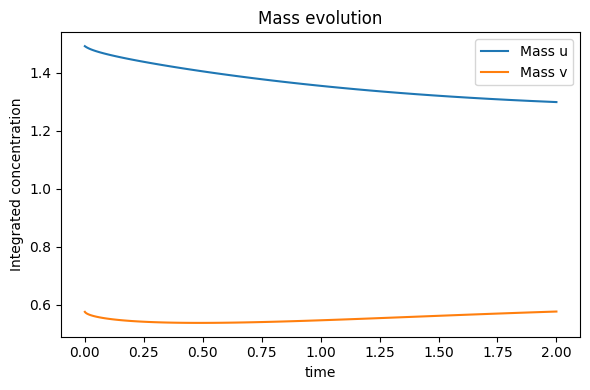

In [4]:
# ---------------------------------------------------------------------------
# Mass evolution
# ---------------------------------------------------------------------------
U_all = sols_sparse[:, :N]
V_all = sols_sparse[:, N:]

mass_u = U_all @ np.ones(N) * prob_sparse.h
mass_v = V_all @ np.ones(N) * prob_sparse.h

plt.figure(figsize=(6,4))
plt.plot(times_sparse, mass_u, label='Mass u')
plt.plot(times_sparse, mass_v, label='Mass v')
plt.xlabel('time')
plt.ylabel('Integrated concentration')
plt.title('Mass evolution')
plt.legend()
plt.tight_layout()
plt.show()



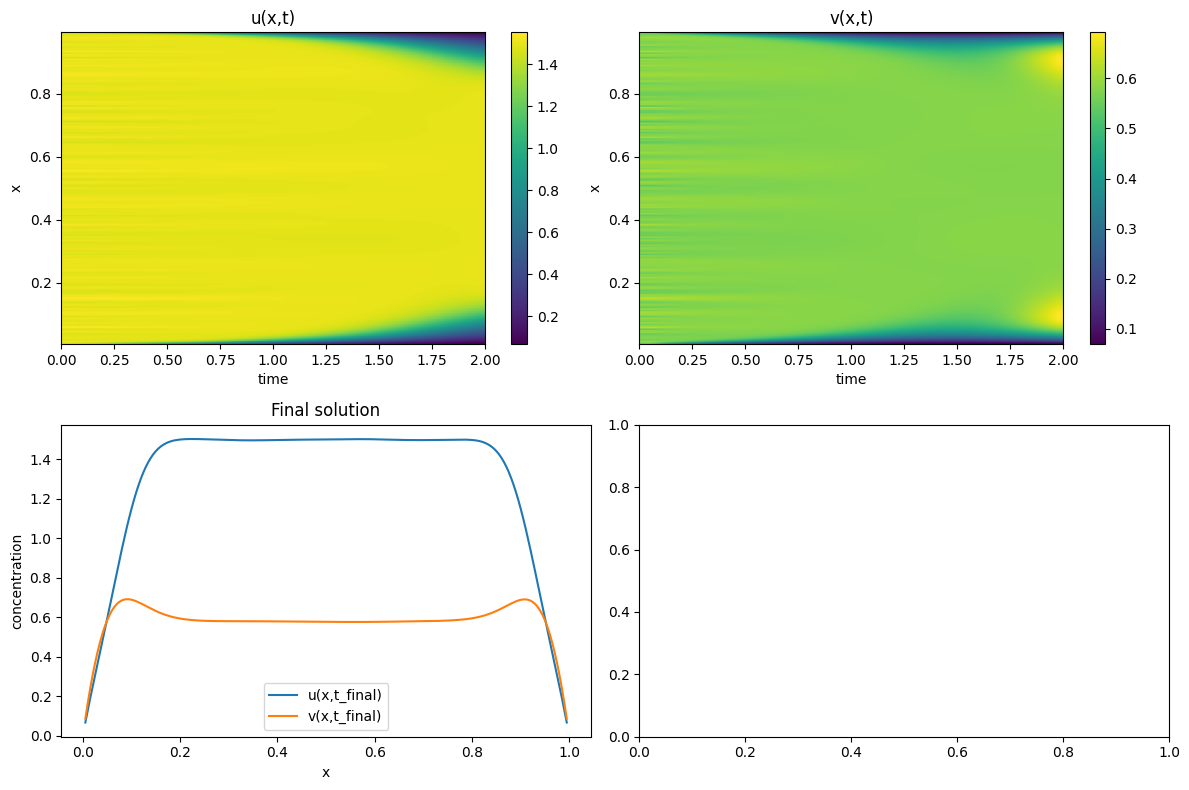

In [5]:
# ---------------------------------------------------------------------------
# Spatio-temporal solution
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2,2, figsize=(12,8))

# Heatmap u
im1 = axes[0,0].imshow(U_all.T, extent=[t_init, t_final, prob_sparse.x[0], prob_sparse.x[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
axes[0,0].set_title("u(x,t)")
axes[0,0].set_xlabel("time")
axes[0,0].set_ylabel("x")
fig.colorbar(im1, ax=axes[0,0])

# Heatmap v
im2 = axes[0,1].imshow(V_all.T, extent=[t_init, t_final, prob_sparse.x[0], prob_sparse.x[-1]],
                        aspect='auto', origin='lower', cmap='viridis')
axes[0,1].set_title("v(x,t)")
axes[0,1].set_xlabel("time")
axes[0,1].set_ylabel("x")
fig.colorbar(im2, ax=axes[0,1])

# Final snapshot
axes[1,0].plot(prob_sparse.x, U_all[-1], label='u(x,t_final)')
axes[1,0].plot(prob_sparse.x, V_all[-1], label='v(x,t_final)')
axes[1,0].set_title("Final solution")
axes[1,0].set_xlabel("x")
axes[1,0].set_ylabel("concentration")
axes[1,0].legend()

plt.tight_layout()
plt.show()



In [ ]:
# ---------------------------------------------------------------------------
# CPU-Time vs N
# ---------------------------------------------------------------------------
Ns = [25, 50, 100, 200, 400, 800, 1600]  # grid sizes. Be patient!
t_final = 0.2             # short final time for benchmarking

results = []

for N in Ns:
    prob_sparse = Schnakenberg1D(N, 0.0, t_final, force_dense=False)
    prob_dense  = Schnakenberg1D(N, 0.0, t_final, force_dense=True)
    
    # Sparse solver
    solver_sparse = RKSolver(auto_check_sparsity =True, **solver_opts)
    t0 = time.perf_counter()
    solver_sparse.solve(prob_sparse)
    t_sparse = time.perf_counter() - t0
    
    # Dense solver
    solver_dense = RKSolver(auto_check_sparsity =False, **solver_opts)
    t0 = time.perf_counter()
    solver_dense.solve(prob_dense)
    t_dense = time.perf_counter() - t0
    
    results.append((N, 2*N, t_dense, t_sparse))

# Print LaTeX table
print("\\begin{table}[ht!]")
print("\\centering")
print("\\begin{tabular}{c|c|c|c}")
print("\\hline")
print("$N$ & Degrees of freedom ($2N$) & Dense solver & Sparse solver \\\\")
print("\\hline")
for N, dof, t_dense, t_sparse in results:
    print(f"{N} & {dof} & {t_dense:.3f} & {t_sparse:.3f} \\\\")
print("\\hline")
print("\\end{tabular}")
print("\\caption{CPU runtimes (in seconds) for the 1D Schnakenberg reaction--diffusion system solved with SDIRK(3,4). Comparison between dense and sparse Jacobian solvers.}")
print("\\label{tab:schnakenberg1d}")
print("\\end{table}")


Sparse Jacobian returned by user: size=50x50, density=7.840e-02
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.
Time step #6 completed. Current time: 0.0072
Time step #7 completed. Current time: 0.0230
Time step #8 completed. Current time: 0.0379
Time step #9 completed. Current time: 0.0536
Time step #10 completed. Current time: 0.0698
Time step #11 completed. Current time: 0.0867
Time step #12 completed. Current time: 0.1043
Time step #13 completed. Current time: 0.1227
Time step #14 completed. Current time: 0.1419
Time step #15 completed. Current time: 0.1620
Time step #16 completed. Current time: 0.1832
Time step #17 completed. Current time: 0.2000
The total number of time steps required to reach t_final = 0.2 is 17.
Dense Jacobian returned by user, using dense: size=50x50
Jacobian marked as variable → will be recomputed at each stage refresh.
Successfully pre-allocated memory for the solution array.
T

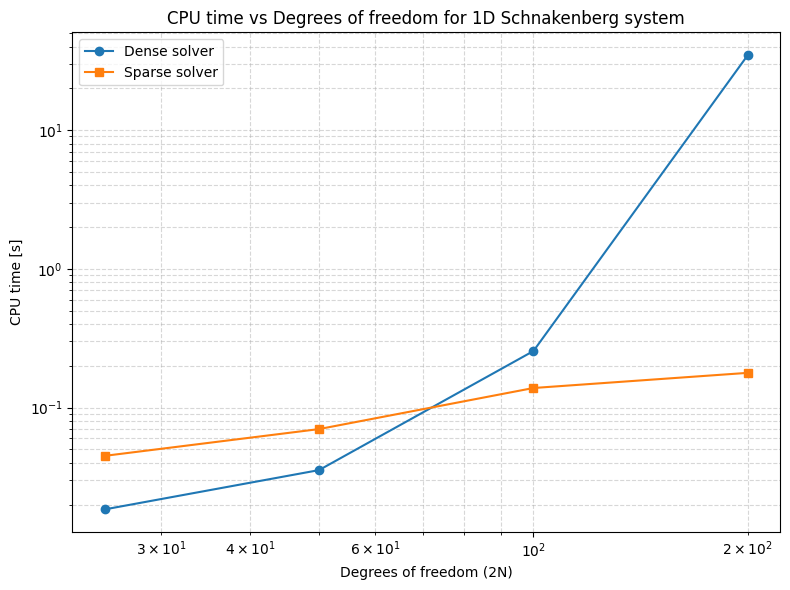

In [8]:
plt.figure(figsize=(8,6))

plt.loglog(Ns, [d[2] for d in results], 'o-', label='Dense solver')
plt.loglog(Ns, [d[3] for d in results], 's-', label='Sparse solver')

plt.xscale('log', base=10)
plt.yscale('log', base=10)

plt.xlabel("Degrees of freedom (2N)")
plt.ylabel("CPU time [s]")
plt.title("CPU time vs Degrees of freedom for 1D Schnakenberg system")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()